label shape: (40, 0)
LDA acct: 0.8625
PCA acc: 0.7625
x_train shape: (320, 20, 64, 64)
len(X_train.shape) 4
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
...done:  MDA_3_3 [0.9375, 0.9625, 0.95, 0.9625, 0.95, 0.95, 0.9375, 0.9625, 0.9625, 0.95]
best accuracy of 0.9625 at iteration 2: 
x_train shape: (320, 20, 64, 64)
len(X_train.shape) 4
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
...done:  MDA_2_2 [0.875, 0.925, 0.9125, 0.925, 0.925, 0.925, 0.9125, 0.925, 0.9375, 0.9375]
best accuracy of 0.9375 at iteration 9: 
x_train shape: (320, 20, 64, 64)
len(X_train.shape) 4
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
...done:  MDA_2_1 [0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925, 0.925]
best accuracy of 0.925 at iteration 

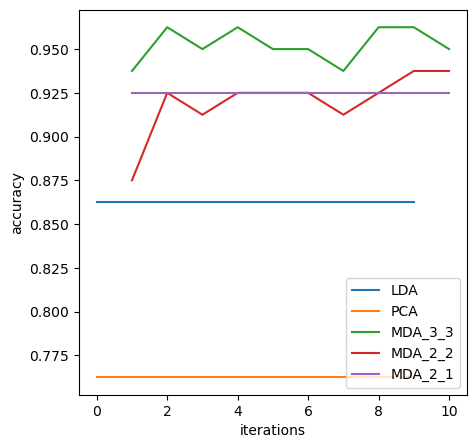

In [2]:
#!pip install tensorly
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorly as tl
import numpy as np
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
tl.set_backend('numpy')
np.random.seed(4321)
import cv2

# Define Gabor filter 
def apply_gabor_filters(image, filters):
    filtered_images = []
    for kernel in filters:
        filtered = cv2.filter2D(image, cv2.CV_32F, kernel)
        filtered_images.append(filtered)
    return np.array(filtered_images)


def compute_B_scat_W_scat(X_train, mode, projection):
    B_scat = 0
    W_scat = 0

    for c in range(num_classes):
        inter_scatter_dist = class_means[c] - global_mean
        mode_dot = tl.tenalg.multi_mode_dot(inter_scatter_dist, projection, transpose=True, skip=mode)
        inter_scatter_unfold = tl.unfold(mode_dot, mode)
        B_scat += num_each_class[c] * tl.dot(inter_scatter_unfold, inter_scatter_unfold.T)
        # inner loop for within-class computation
    for c in range(num_classes):
        for j in range(num_each_class[c]):
            # subtract mean for person c from jth image of cth person
            intra_scatter_dist = X_train[label[c][j]] - class_means[c]
            mode_dot = tl.tenalg.multi_mode_dot(intra_scatter_dist, projection, transpose=True, skip=mode)
            intra_scatter_unfold = tl.unfold(mode_dot,mode)
            W_scat += tl.dot(intra_scatter_unfold,intra_scatter_unfold.T)
    return B_scat, W_scat

    #B_scat, W_scat = compute_mode_k_scatters(0, factors)

def min_dist_classification(X_train, X_test, y_train, y_test):
    pred = []
    for each_test in X_test:
        min_dist = np.infty
        predict_label = -1
        for each_train, each_label in zip(X_train, y_train):
            dist = tl.norm(each_test - each_train).mean()
            if dist < min_dist:
                min_dist = dist;
                prediction = each_label.item()
                
        pred +=[int(prediction)]
    acc = (pred==tl.to_numpy(y_test)).mean()
    return acc


faces = datasets.fetch_olivetti_faces()
X = faces.images
data = faces.data
y = faces.target
rank = 16

total_iters = 10

u_uniqued = np.unique(y)
num_classes = len(u_uniqued)
label = [[] for _ in range(len(u_uniqued))]

print("label shape:", np.shape(label))
# create a test set and a training set
idx = np.arange(len(X))
np.random.shuffle(idx)
num_data = len(X)
num_train = round(num_data * 0.6)

train = idx[:num_train]
test = idx[num_train:]

y_train, y_test = y[train], y[test]
data_train, data_test = data[train], data[test]
#data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.6, stratify=y)

plt.figure(figsize=(5, 5))

lda = LinearDiscriminantAnalysis(n_components=rank)
lda.fit(data_train, y_train)

LDA_train = lda.transform(data_train)
LDA_test = lda.transform(data_test)
lda_acc = min_dist_classification(tl.tensor(LDA_train), tl.tensor(LDA_test), y_train, y_test)

print("LDA acct:", lda_acc)
plt.plot(list(range(total_iters)), [lda_acc] * total_iters, label='LDA')


pca = PCA(n_components=rank)
pca.fit(data_train, y_train)

PCA_train = pca.transform(data_train)
PCA_test = pca.transform(data_test)
pca_acc = min_dist_classification(tl.tensor(PCA_train), tl.tensor(PCA_test), y_train, y_test)
plt.plot(list(range(total_iters)), [pca_acc] * total_iters, label='PCA')

print("PCA acc:", pca_acc)
plt.xlabel('iterations')
plt.ylabel('accuracy')

# Define Gabor filter parameters
ksize = 7
sigma = 6
theta = [0, np.pi/4, np.pi/2, 3*np.pi/4]
lambd = 16
gamma = 0.5
psi = 0

# Create Gabor filter
filters = []
#for t in range(len(theta)):
for s in range(1, 21):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, s*np.pi/20, lambd, gamma, psi, ktype=cv2.CV_32F)
    filters.append(kernel)

# Gabor filtering on each image
filtered_X = []
for image in X:
    filtered = apply_gabor_filters(image, filters)
    filtered_X.append(filtered)

filtered_X = np.array(filtered_X)

    
for algo_mode in [ "MDA_3_3", "MDA_2_2", "MDA_2_1"] :
    
    if algo_mode == "MDA_3_3":
        X = filtered_X
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    
    #X_train, X_test, y_train, y_test = train_test_split(tl.tensor(X), y, test_size=0.8, stratify=y)
    #if algo_mode == "MDA_3_3":
    #    img_shape = [-1, X_train.shape[1] * X_train.shape[2]* X_train.shape[3]]
    #else:
    #    img_shape = [-1, X_train.shape[1] * X_train.shape[2]]

    #data_train = X_train.reshape(img_shape)
    #data_test = X_test.reshape(img_shape)

    num_modes = len(X_train.shape) - 1

    global_mean = tl.mean(X_train, axis=0)
    class_means = []

    print("x_train shape:", X_train.shape)
    #sort the image idx to its corresponding label
    for i, identity in enumerate(y_train):
        label[identity] += [i]

    for i, person_idx in enumerate(label):
        class_means += [tl.mean(X_train[person_idx], axis=0)]

    #print("The sorted labels are: ", label)

    #plt.figure(figsize=(2, 2))
    #plt.imshow(global_mean, cmap='gray')
    #plt.title('Global mean face')

    #fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    #for i, ax in enumerate(axs):
    #    ax.imshow(class_means[i], cmap='gray')
    #    ax.set_title('subclass mean face {}'.format(i))

    num_each_class = [len(p) for p in label]

    print("len(X_train.shape)",len(X_train.shape))
    #projection = [tl.ones((dim, rank)) for i, dim in enumerate(list(X_train.shape[1:]))]

    # dimension of desired low-dim subspace (shared across all modes)

    accs = []
    its = []
    last_acc = 0
    current_acc = 0
    finish_it = 0
    max_acc = 0.6
    
    # initialise the factor matrices as 1 matrices.
    projection = [tl.ones((dim, 5)) for i, dim in enumerate(list(X_train.shape)[1:])]
    for t in range(1, total_iters + 1):
        print('iteration:', t)
        for k in range(num_modes):
            B_scat, W_scat = compute_B_scat_W_scat(X_train, k, projection)        
            U, _, _ = tl.tenalg.svd_interface(tl.dot(np.linalg.inv(W_scat),  B_scat), n_eigenvecs=20)
            projection[k] = U
            #print(U.shape)

        #project the train set and the test set to the projection tensor at this iteration 
        if algo_mode == "MDA_2_1":
            Z_train = tl.tenalg.multi_mode_dot(X_train, projection,modes=[1], transpose=True)
            Z_test = tl.tenalg.multi_mode_dot(X_test, projection, modes=[1], transpose=True)
        if algo_mode == "MDA_2_2":
            Z_train = tl.tenalg.multi_mode_dot(X_train, projection,modes=[1,2], transpose=True)
            Z_test = tl.tenalg.multi_mode_dot(X_test, projection, modes=[1,2], transpose=True)
        if algo_mode == "MDA_3_3":
            Z_train = tl.tenalg.multi_mode_dot(X_train, projection,modes=[1, 2], transpose=True)
            Z_test = tl.tenalg.multi_mode_dot(X_test, projection, modes=[1, 2], transpose=True)

        #calculate the accuracy at this iteration
        curr_acc = min_dist_classification(Z_train, Z_test, y_train, y_test)
        if max_acc < curr_acc:
            max_acc = curr_acc;
        accs += [curr_acc]
        its += [t]

       # if curr_acc - last_acc < 0.01:
       #     if finish_it == 0:
       #         finish_it = t
       #break
        #last_acc = curr_acc


    print('...done: ', algo_mode, accs)
    print('best accuracy of {} at iteration {}: '.format(np.max(np.array(accs)), its[np.argmax(np.array(accs))] ))
    plt.plot(its, accs, label=algo_mode)
#score = min_dist_classification(X_train, X_test, y_train, y_test)
#img_shape = [-1, X_train.shape[1] * X_train.shape[2] *  X_train.shape[3]]
# create the models


plt.legend()
plt.show()

# evaluate everything
